### Regression between Moldindex, NTA Level ACS Data, and Asthma Cases per NTA

Analysis should give an idea about the relationship of mold to asthma. 


Two regressions will be done: 

all attributes vs age adjusted adult asthma  rate

All attributes vs children asthma rate

#### Author: Matthias Fitzky

In [14]:




import pandas as pd
import geopandas as gpd
%pylab inline
import statsmodels.formula.api as smf    # for OLS regression
import numpy as np
import matplotlib as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split 
from sklearn.metrics import r2_score
from sklearn import linear_model
from sklearn import preprocessing
import statsmodels.api as sm
import matplotlib.pylab as plt
from sklearn.model_selection import GridSearchCV
import math
import seaborn as sns
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


c:\ProgramData\Miniconda3\envs\testv37\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [15]:
#Load Nta geometries
NTA=gpd.read_file(r"..\Data\NTA map.geojson")
NTA=NTA.to_crs('EPSG:6539')
NTA['SqMi_area']=NTA.area * 3.58701e-8
#Transforming back to input epsg for Data continuity purposes
NTA=NTA.to_crs('EPSG:4326')

In [16]:
#Load ACS:
ACS=pd.read_csv(r'../Output/acs_nta_agg.csv')

In [17]:
ACS_Geo = NTA.merge(ACS,on='ntacode')

In [18]:
#load NTA Level Moldindex
MoldIndex=pd.read_csv(r'../Output/Moldindex_NTA.csv')

#Make Mold Geo
MoldIndexGeo=NTA.merge(MoldIndex,on='ntacode')[['ntacode','geometry','Moldindex']]

In [19]:
#load NTA Level Asthma Data

NTA_ASthma=gpd.read_file('../Output/asthma_er_nta.zip')[['ntacode','asth_a_a_r','asth_c_r']]
NTA_ASthmaGeo=NTA.merge(NTA_ASthma,on='ntacode',how='left')[['ntacode','asth_a_a_r','asth_c_r','geometry']]

In [20]:
gpd.read_file('../Output/asthma_er_nta.zip')

,boro_code,boro_name,county_fip,ntacode,ntaname,asth_a_a_r,asth_a_n,asth_a_r,asth_c_n,asth_c_r,geometry
0,4.0,Queens,081,QN08,St. Albans,86.5,357,85.3,118,157.1,"POLYGON ((-73.75205 40.70523, -73.75174 40.704..."
1,2.0,Bronx,005,BX28,Van Cortlandt Village,90.3,351,90.2,194,239.7,"POLYGON ((-73.88705 40.88435, -73.88705 40.884..."
2,4.0,Queens,081,QN55,South Ozone Park,54.3,342,54.5,119,93.0,"POLYGON ((-73.80577 40.68293, -73.80552 40.682..."
3,3.0,Brooklyn,047,BK40,Windsor Terrace,33.0,55,29.2,7,27.6,"POLYGON ((-73.98017 40.66115, -73.98021 40.661..."
4,3.0,Brooklyn,047,BK50,Canarsie,102.4,672,101.5,257,197.2,"MULTIPOLYGON (((-73.88834 40.64671, -73.88835 ..."
...,...,...,...,...,...,...,...,...,...,...,...
183,2.0,Bronx,005,BX34,Melrose South-Mott Haven North,309.1,941,310.5,358,425.4,"POLYGON ((-73.90129 40.82048, -73.90160 40.819..."
184,2.0,Bronx,005,BX39,Mott Haven-Port Morris,320.2,1247,320.2,586,565.8,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ..."
185,2.0,Bronx,005,BX63,West Concourse,211.2,594,216.4,269,386.7,"POLYGON ((-73.91192 40.84326, -73.91195 40.843..."
186,5.0,Staten Island,085,SI22,West New Brighton-New Brighton-St. George,185.2,442,180.3,162,274.9,"POLYGON ((-74.07258 40.63794, -74.07330 40.637..."


In [21]:
# fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
# ax1 = NTA_ASthmaGeo.plot(ax=ax1,column='asth_c_r', missing_kwds= dict(color = "lightgrey",),legend=True )
# ax2 = MoldIndexGeo.plot(ax=ax2, column='Moldindex', legend=True, missing_kwds= dict(color = "lightgrey",))
# ax3 = ACS_Geo.plot(ax=ax3, column='total_workers',legend=True, missing_kwds= dict(color = "lightgrey",))
# ax4 = ACS_Geo.plot(ax=ax4, column='d_Total population',legend=True, missing_kwds= dict(color = "lightgrey",))


# ax1.title.set_text('Children Asthma Rate')
# ax2.title.set_text('Moldindex')
# ax3.title.set_text('ACS Data total_workers (Source: ACS race+income datasets)')
# ax4.title.set_text('ACS Data d_Total Pop (Source: ACS age_sex datasets)')
# # plt.tight_layout(pad=1)

In [22]:
# Freature Engineering Decisions: 

# Drop Age Gorups alltogether.  
# Total pop is kept absolute numbers
# Female pop as percentage of total property
# Non white pop: (( total pop - white) / total pop) (describes percentage of non whiyte)
# Delete evertthing from white no lat - hispanic or latino
#use median agew as is
# Average size of households: Total pop / household number
#drop household and family household number
# use median income  as is
# use gini  as is
# total workerss div. total pop
# poverty / total pop 
# income per capita as is 
# Drop the rest

In [23]:
#Feature Engineering: keep only relevant attributes, minimize correlation. 

#Drop duplicate Total pop column
ACS_Geo=ACS_Geo.drop(columns=['total_population'])
#Drop Shapefile attributes
ACS_Geo=ACS_Geo.drop(columns=['ntaname','shape_area', 'shape_leng', 'boroname', 'borocode', 'countyfips'])
#Drop Age Buckets
ACS_Geo=ACS_Geo.drop(columns=['d_Under 5 years','d_5 to 9 years','d_10 to 14 years','d_15 to 19 years','d_20 to 24 years','d_25 to 29 years','d_30 to 34 years'
                               ,'d_35 to 39 years','d_40 to 44 years','d_45 to 49 years','d_50 to 54 years','d_55 to 59 years','d_60 to 64 years','d_65 to 69 years'
                               ,'d_70 to 74 years','d_75 to 79 years','d_80 to 84 years','d_85 years and over'])
#Female proportion as percentage
ACS_Geo['Female_Pop_Percentage']=ACS_Geo['d_tot_female_pop']/ACS_Geo['d_Total population']
ACS_Geo=ACS_Geo.drop(columns=['d_tot_female_pop'])
#Non White Pop Percentage adn drop all other race columns
ACS_Geo['NonWhite_Pop_percentage'] = (( ACS_Geo['d_Total population'] - ACS_Geo['white_no_lat']) / ACS_Geo['d_Total population'])
ACS_Geo=ACS_Geo.drop(columns=['white_no_lat','black_no_lat','native_no_lat','asian_no_lat','pacific_no_lat','other_race_no_lat','two_or_more_no_lat','hispanic_or_latino'])
#Avg Size of households (Mold appears where a lot of human activities in households are. Therefore the higher the Household member count, the more molod there potentially is
ACS_Geo['Avg_Size_Households'] = ACS_Geo['d_Total population'] / ACS_Geo['household_number']
#Drop Households and family households
ACS_Geo=ACS_Geo.drop(columns=['household_number','family_households_number'])
#Proportion of Total workers
ACS_Geo['total_workers_percentage'] = ACS_Geo['total_workers'] / ACS_Geo['d_Total population']
ACS_Geo=ACS_Geo.drop(columns=['total_workers'])
#Proportion of poverty against total pop
ACS_Geo['poverty_status_percentage'] = ACS_Geo['poverty_status'] / ACS_Geo['d_Total population']
ACS_Geo=ACS_Geo.drop(columns=['poverty_status'])
#PopDensity
ACS_Geo['Popdensity_perSqMi'] = ACS_Geo['d_Total population'] / ACS_Geo['SqMi_area'].astype(float)
ACS_Geo=ACS_Geo.drop(columns='SqMi_area')

<AxesSubplot:>

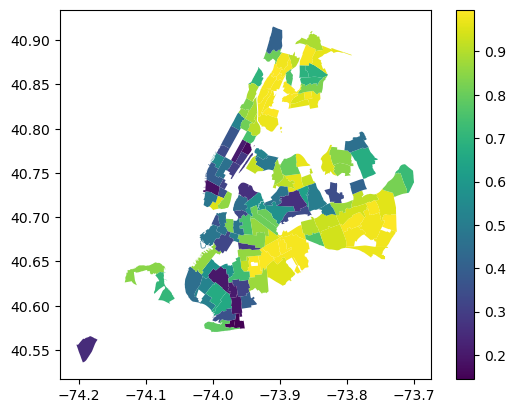

In [24]:
ACS_Geo.plot(column='NonWhite_Pop_percentage',legend=True)

### Regression for Children Asthma Rate per 100k

In [25]:
#Regression Dataset for Children Asthma Cases
ChildrenAsthmaMold=MoldIndexGeo.merge(NTA_ASthmaGeo,on='ntacode')[['ntacode','Moldindex','asth_c_r']]
ACS_Mold_AsthmaC = ChildrenAsthmaMold.merge(ACS_Geo.iloc[:, [0] + list(range(2, 13))],on='ntacode')


In [26]:
from sklearn.preprocessing import StandardScaler
#Drop Nans incompatible with Regressions.
ACS_Mold_AsthmaC.dropna(inplace=True)
print(ACS_Mold_AsthmaC.shape)
# Define the features and target variable
X = ACS_Mold_AsthmaC.drop(['asth_c_r','ntacode'], axis=1)
y = ACS_Mold_AsthmaC['asth_c_r']

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler to the features
scaler.fit(X)

# Transform the features
X_scaled = scaler.transform(X)

# Print the mean and standard deviation of the scaled features
print('Mean:', X_scaled.mean(axis=0))
print('Standard deviation:', X_scaled.std(axis=0))
X_scaledDF=pd.DataFrame(data=X_scaled,columns=X.columns)

(141, 14)
Mean: [ 1.88974132e-16 -1.25982755e-17 -3.71649126e-16 -1.25982755e-17
 -1.88974132e-17  3.77948264e-17  8.56682731e-16  1.88974132e-16
  2.26768958e-16  2.51965509e-17  2.51965509e-17 -1.88974132e-17]
Standard deviation: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


<AxesSubplot:>

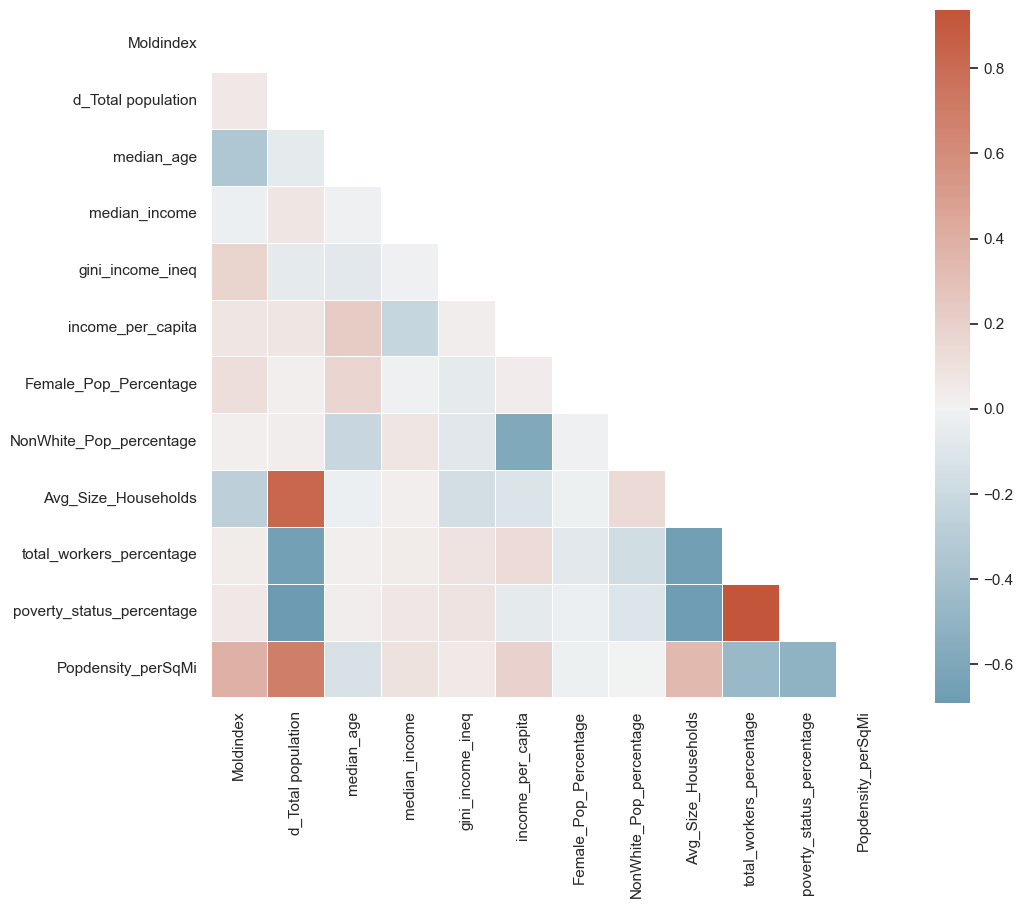

In [27]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

# Generate a large random dataset
d= X_scaledDF

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5)

In [28]:
#Array to store all Out of sample R2 accuracies. Listed at the very bottom for analysis. 
OSR2Array = []

## Regression Children Asthma Cases with Mold Index

(141, 14)
Mean: [ 1.88974132e-16 -1.25982755e-17 -3.71649126e-16 -1.25982755e-17
 -1.88974132e-17  3.77948264e-17  8.56682731e-16  1.88974132e-16
  2.26768958e-16  2.51965509e-17  2.51965509e-17 -1.88974132e-17]
Standard deviation: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(112, 12)
(112,)
(29, 12)
(29,)
The IS R-squared of ElaticNet is: 0.6742546102898691
The OS R-squared of ElasticNet is: 0.6417400490764474


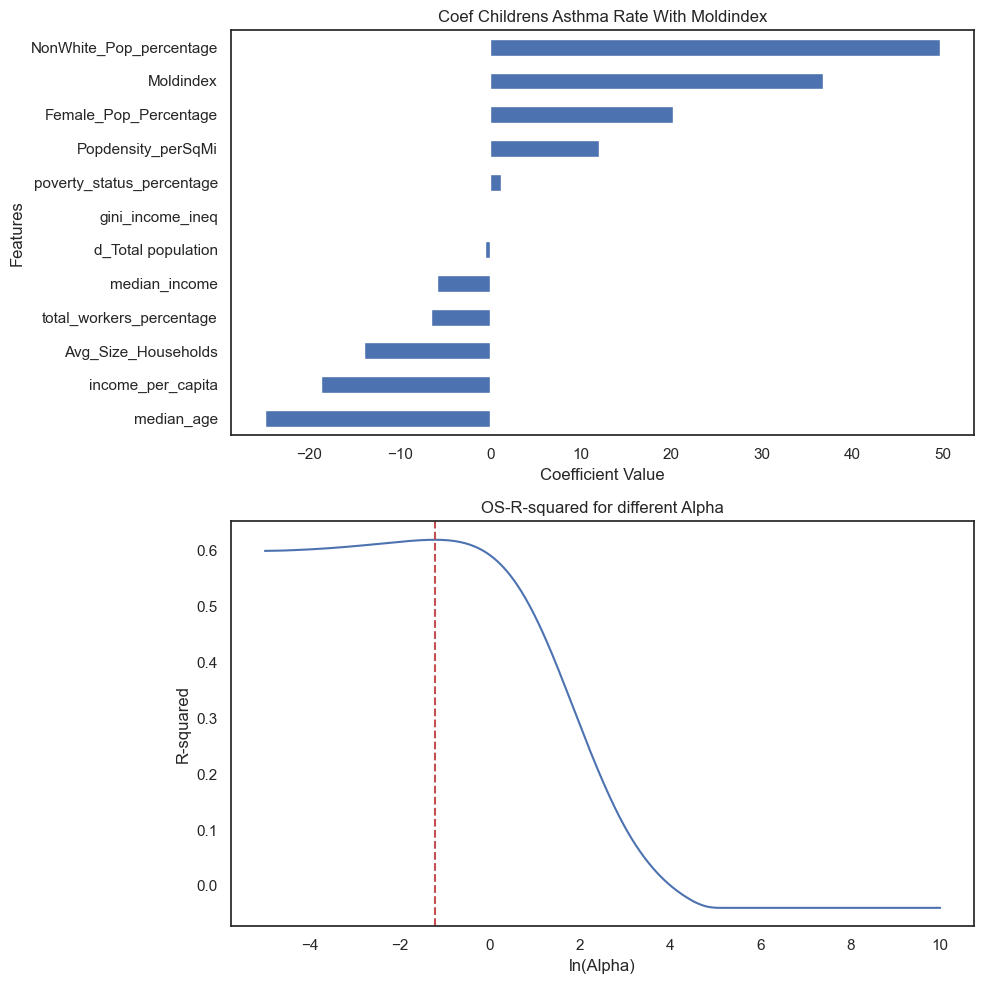

best Alpha 0.29193291938725824


In [29]:

### Test without Alpha Search

#Regression Dataset for Adults Asthma Cases
AdultsAsthmaMold=MoldIndexGeo.merge(NTA_ASthmaGeo,on='ntacode')[['ntacode','Moldindex','asth_c_r']]
ACS_Mold_AsthmaC = AdultsAsthmaMold.merge(ACS_Geo.iloc[:, [0] + list(range(2, 13))],on='ntacode')

#Drop Nans incompatible with Regressions.
ACS_Mold_AsthmaC.dropna(inplace=True)
print(ACS_Mold_AsthmaC.shape)
# Define the features and target variable
X = ACS_Mold_AsthmaC.drop(['asth_c_r','ntacode'], axis=1)
y = ACS_Mold_AsthmaC['asth_c_r']

# Initialize the StandardScaler
scaler = StandardScaler()
# Fit the scaler to the features
scaler.fit(X)
# Transform the features
X_scaled = scaler.transform(X)
# Print the mean and standard deviation of the scaled features
print('Mean:', X_scaled.mean(axis=0))
print('Standard deviation:', X_scaled.std(axis=0))
X_scaledDF=pd.DataFrame(data=X_scaled,columns=X.columns)


#Elasticnet Regression
# Let's say we want to split the data in 80:20 for train:test dataset
from sklearn.model_selection import train_test_split
# In the first step we will split the data in training and remaining dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaledDF,y, train_size=0.8,random_state=79)
print(X_train.shape), print(y_train.shape)
print(X_test.shape), print(y_test.shape)

alphas = np.exp(np.linspace(-5,10,1000))
ElasticNet=linear_model.ElasticNet(fit_intercept=True)
param_grid={'alpha':alphas}
#Gridsearch with 5 times crossvalidation
gs = GridSearchCV(ElasticNet, param_grid=param_grid, scoring='r2', cv=5)
rs = gs.fit(X_train,y_train)
# In sample:
YPred_IS=rs.best_estimator_.predict(X_train)
print("The IS R-squared of ElaticNet is: {0}".format(r2_score(y_train,YPred_IS)))
#Out of sample
YPred_OS=rs.best_estimator_.predict(X_test)
print("The OS R-squared of ElasticNet is: {0}".format(r2_score(y_test,YPred_OS)))
OSR2Array.append(r2_score(y_test,YPred_OS))

rs.best_estimator_.coef_
CoeffElasticNet=pd.DataFrame(rs.best_estimator_.coef_).transpose()
CoeffElasticNet.columns=X.columns
CoeffElasticNet=CoeffElasticNet.transpose()
# CoeffElasticNet.sort_values(by=0,ascending=True).plot.barh(title='Coef Elasticnet asth_c_r')
# data=pd.DataFrame(y_train).join(pd.DataFrame(YPred_IS,columns=['ypred']))



# Create a 1x2 subplot layout
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plot the coefficient values in a horizontal bar plot
CoeffElasticNet.sort_values(by=0, ascending=True).plot.barh(title='Coef Childrens Asthma Rate With Moldindex', ax=axs[0],legend=False)
axs[0].set_xlabel('Coefficient Value')
axs[0].set_ylabel('Features')

# Plot the alpha values vs R-squared values
axs[1].plot(np.log(alphas), gs.cv_results_['mean_test_score'])
axs[1].set_title('OS-R-squared for different Alpha')
axs[1].set_xlabel('ln(Alpha)')
axs[1].set_ylabel('R-squared')
#insert dashed line indicating best alpha
bl=np.log(rs.best_params_['alpha'])
axs[1].axvline(bl,color='r',linestyle='--')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

print('best Alpha' ,rs.best_params_['alpha'])

## Regression Adults Asthma Rates with Mold Index

(141, 14)
Mean: [ 1.88974132e-16 -1.25982755e-17 -3.71649126e-16 -1.25982755e-17
 -1.88974132e-17  3.77948264e-17  8.56682731e-16  1.88974132e-16
  2.26768958e-16  2.51965509e-17  2.51965509e-17 -1.88974132e-17]
Standard deviation: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(112, 12)
(112,)
(29, 12)
(29,)
The IS R-squared of ElaticNet is: 0.6188158587619512
The OS R-squared of ElasticNet is: 0.6751699500691506


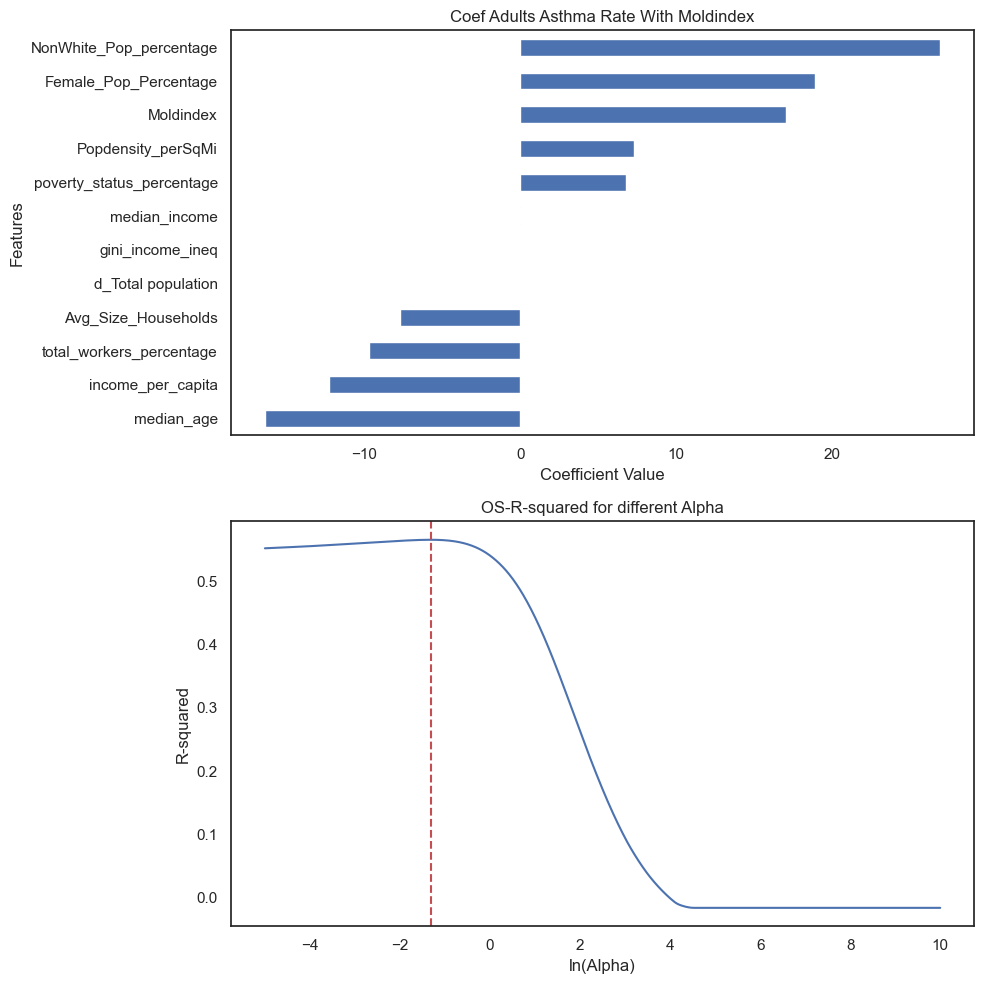

best Alpha 0.26678256348744167


In [30]:

### Test without Alpha Search

#Regression Dataset for Adults Asthma Cases
AdultsAsthmaMold=MoldIndexGeo.merge(NTA_ASthmaGeo,on='ntacode')[['ntacode','Moldindex','asth_a_a_r']]
ACS_Mold_AsthmaA = AdultsAsthmaMold.merge(ACS_Geo.iloc[:, [0] + list(range(2, 13))],on='ntacode')

#Drop Nans incompatible with Regressions.
ACS_Mold_AsthmaA.dropna(inplace=True)
print(ACS_Mold_AsthmaA.shape)
# Define the features and target variable
X = ACS_Mold_AsthmaA.drop(['asth_a_a_r','ntacode'], axis=1)
y = ACS_Mold_AsthmaA['asth_a_a_r']

# Initialize the StandardScaler
scaler = StandardScaler()
# Fit the scaler to the features
scaler.fit(X)
# Transform the features
X_scaled = scaler.transform(X)
# Print the mean and standard deviation of the scaled features
print('Mean:', X_scaled.mean(axis=0))
print('Standard deviation:', X_scaled.std(axis=0))
X_scaledDF=pd.DataFrame(data=X_scaled,columns=X.columns)


#Elasticnet Regression
# Let's say we want to split the data in 80:20 for train:test dataset
from sklearn.model_selection import train_test_split
# In the first step we will split the data in training and remaining dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaledDF,y, train_size=0.8,random_state=79)
print(X_train.shape), print(y_train.shape)
print(X_test.shape), print(y_test.shape)

alphas = np.exp(np.linspace(-5,10,1000))
ElasticNet=linear_model.ElasticNet(fit_intercept=True)
param_grid={'alpha':alphas}
#Gridsearch with 5 times crossvalidation
gs = GridSearchCV(ElasticNet, param_grid=param_grid, scoring='r2', cv=5)
rs = gs.fit(X_train,y_train)
# In sample:
YPred_IS=rs.best_estimator_.predict(X_train)
print("The IS R-squared of ElaticNet is: {0}".format(r2_score(y_train,YPred_IS)))
#Out of sample
YPred_OS=rs.best_estimator_.predict(X_test)
print("The OS R-squared of ElasticNet is: {0}".format(r2_score(y_test,YPred_OS)))
OSR2Array.append(r2_score(y_test,YPred_OS))

rs.best_estimator_.coef_
CoeffElasticNet=pd.DataFrame(rs.best_estimator_.coef_).transpose()
CoeffElasticNet.columns=X.columns
CoeffElasticNet=CoeffElasticNet.transpose()
# CoeffElasticNet.sort_values(by=0,ascending=True).plot.barh(title='Coef Elasticnet asth_a_a_r')
# data=pd.DataFrame(y_train).join(pd.DataFrame(YPred_IS,columns=['ypred']))


# Create a 1x2 subplot layout
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plot the coefficient values in a horizontal bar plot
CoeffElasticNet.sort_values(by=0, ascending=True).plot.barh(title='Coef Adults Asthma Rate With Moldindex', ax=axs[0],legend=False)
axs[0].set_xlabel('Coefficient Value')
axs[0].set_ylabel('Features')

# Plot the alpha values vs R-squared values
axs[1].plot(np.log(alphas), gs.cv_results_['mean_test_score'])
axs[1].set_title('OS-R-squared for different Alpha')
axs[1].set_xlabel('ln(Alpha)')
axs[1].set_ylabel('R-squared')
#insert dashed line indicating best alpha
bl=np.log(rs.best_params_['alpha'])
axs[1].axvline(bl,color='r',linestyle='--')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

print('best Alpha' ,rs.best_params_['alpha'])

## Regression Children Asthma Rates without Mold Index

(141, 14)
Mean: [-1.25982755e-17 -3.71649126e-16 -1.25982755e-17 -1.88974132e-17
  3.77948264e-17  8.56682731e-16  1.88974132e-16  2.26768958e-16
  2.51965509e-17  2.51965509e-17 -1.88974132e-17]
Standard deviation: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(112, 11)
(112,)
(29, 11)
(29,)
The IS R-squared of ElaticNet is: 0.6355733133797006
The OS R-squared of ElasticNet is: 0.5383837885509453


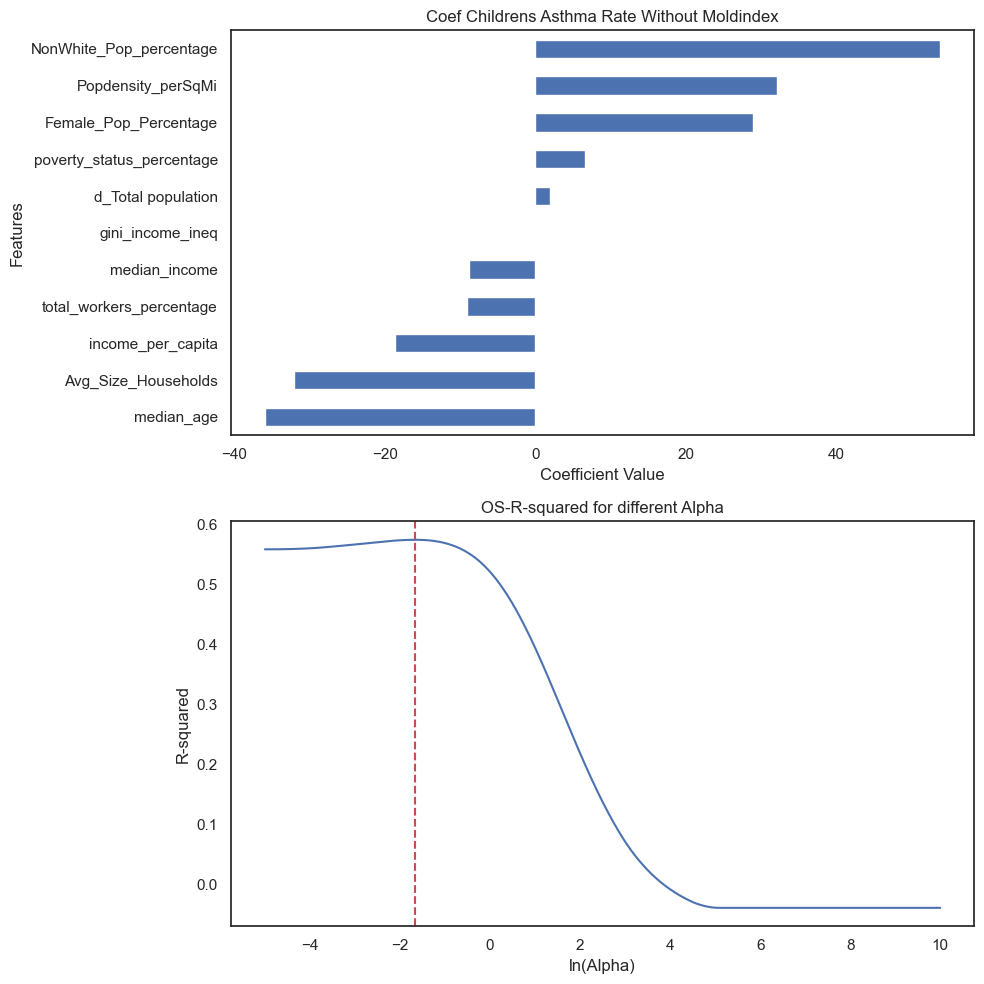

best Alpha 0.18887560283756186


In [31]:

### Test without Alpha Search

#Regression Dataset for Adults Asthma Cases
AdultsAsthmaMold=MoldIndexGeo.merge(NTA_ASthmaGeo,on='ntacode')[['ntacode','Moldindex','asth_c_r']]
ACS_Mold_AsthmaC = AdultsAsthmaMold.merge(ACS_Geo.iloc[:, [0] + list(range(2, 13))],on='ntacode')

#Drop Nans incompatible with Regressions.
ACS_Mold_AsthmaC.dropna(inplace=True)
print(ACS_Mold_AsthmaC.shape)
# Define the features and target variable
X = ACS_Mold_AsthmaC.drop(['asth_c_r','ntacode','Moldindex'], axis=1)
y = ACS_Mold_AsthmaC['asth_c_r']

# Initialize the StandardScaler
scaler = StandardScaler()
# Fit the scaler to the features
scaler.fit(X)
# Transform the features
X_scaled = scaler.transform(X)
# Print the mean and standard deviation of the scaled features
print('Mean:', X_scaled.mean(axis=0))
print('Standard deviation:', X_scaled.std(axis=0))
X_scaledDF=pd.DataFrame(data=X_scaled,columns=X.columns)


#Elasticnet Regression
# Let's say we want to split the data in 80:20 for train:test dataset
from sklearn.model_selection import train_test_split
# In the first step we will split the data in training and remaining dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaledDF,y, train_size=0.8,random_state=79)
print(X_train.shape), print(y_train.shape)
print(X_test.shape), print(y_test.shape)

alphas = np.exp(np.linspace(-5,10,1000))
ElasticNet=linear_model.ElasticNet(fit_intercept=True)
param_grid={'alpha':alphas}
#Gridsearch with 5 times crossvalidation
gs = GridSearchCV(ElasticNet, param_grid=param_grid, scoring='r2', cv=5)
rs = gs.fit(X_train,y_train)
# In sample:
YPred_IS=rs.best_estimator_.predict(X_train)
print("The IS R-squared of ElaticNet is: {0}".format(r2_score(y_train,YPred_IS)))
#Out of sample
YPred_OS=rs.best_estimator_.predict(X_test)
print("The OS R-squared of ElasticNet is: {0}".format(r2_score(y_test,YPred_OS)))
OSR2Array.append(r2_score(y_test,YPred_OS))

rs.best_estimator_.coef_
CoeffElasticNet=pd.DataFrame(rs.best_estimator_.coef_).transpose()
CoeffElasticNet.columns=X.columns
CoeffElasticNet=CoeffElasticNet.transpose()
# CoeffElasticNet.sort_values(by=0,ascending=True).plot.barh(title='Coef Elasticnet asth_c_r')
# data=pd.DataFrame(y_train).join(pd.DataFrame(YPred_IS,columns=['ypred']))


# Create a 1x2 subplot layout
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plot the coefficient values in a horizontal bar plot
CoeffElasticNet.sort_values(by=0, ascending=True).plot.barh(title='Coef Childrens Asthma Rate Without Moldindex', ax=axs[0],legend=False)
axs[0].set_xlabel('Coefficient Value')
axs[0].set_ylabel('Features')

# Plot the alpha values vs R-squared values
axs[1].plot(np.log(alphas), gs.cv_results_['mean_test_score'])
axs[1].set_title('OS-R-squared for different Alpha')
axs[1].set_xlabel('ln(Alpha)')
axs[1].set_ylabel('R-squared')
#insert dashed line indicating best alpha
bl=np.log(rs.best_params_['alpha'])
axs[1].axvline(bl,color='r',linestyle='--')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()
print('best Alpha' ,rs.best_params_['alpha'])

### Regression Adults Asthma Rate without Mold Index

(141, 14)
Mean: [-1.25982755e-17 -3.71649126e-16 -1.25982755e-17 -1.88974132e-17
  3.77948264e-17  8.56682731e-16  1.88974132e-16  2.26768958e-16
  2.51965509e-17  2.51965509e-17 -1.88974132e-17]
Standard deviation: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(112, 11)
(112,)
(29, 11)
(29,)
The IS R-squared of ElaticNet is: 0.6128634196609857
The OS R-squared of ElasticNet is: 0.5935210749865811


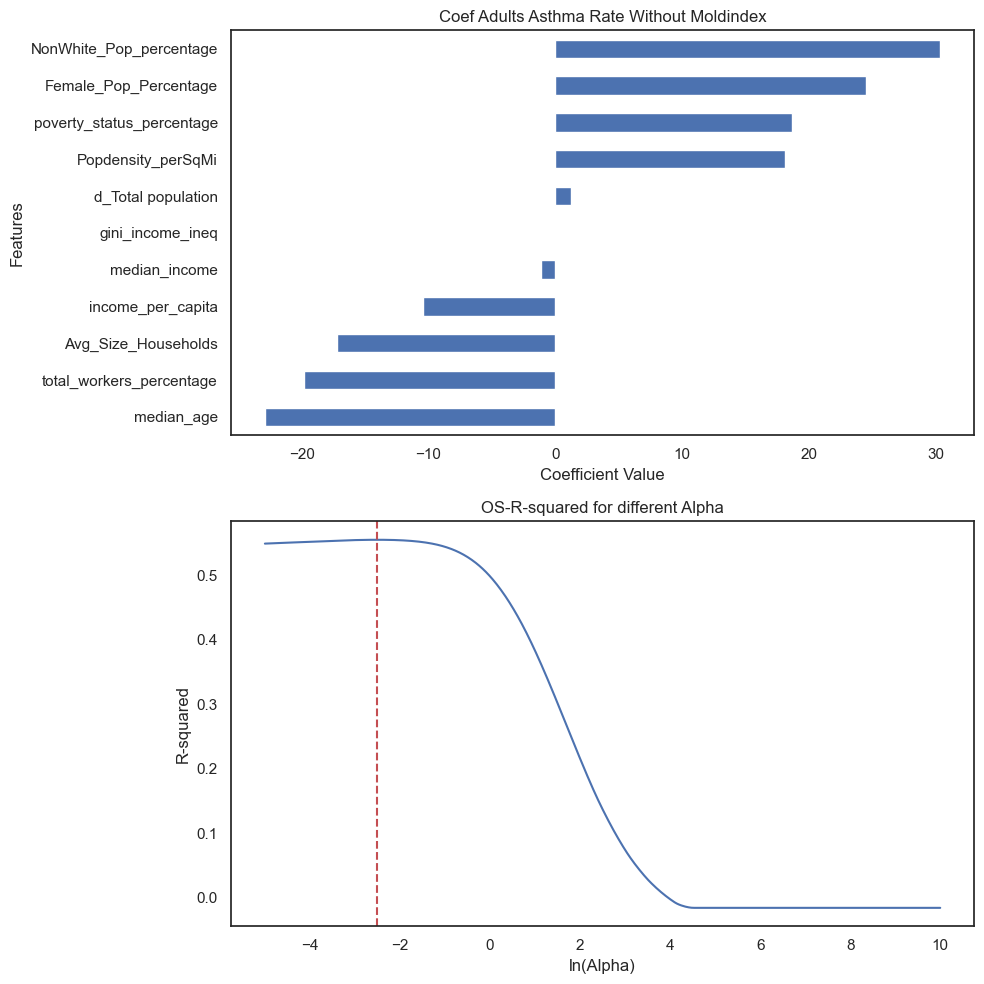

best Alpha 0.08147105236717667


In [32]:

### Test without Alpha Search

#Regression Dataset for Adults Asthma Cases
AdultsAsthmaMold=MoldIndexGeo.merge(NTA_ASthmaGeo,on='ntacode')[['ntacode','Moldindex','asth_a_a_r']]
ACS_Mold_AsthmaA = AdultsAsthmaMold.merge(ACS_Geo.iloc[:, [0] + list(range(2, 13))],on='ntacode')

#Drop Nans incompatible with Regressions.
ACS_Mold_AsthmaA.dropna(inplace=True)
print(ACS_Mold_AsthmaA.shape)
# Define the features and target variable
X = ACS_Mold_AsthmaA.drop(['asth_a_a_r','ntacode','Moldindex'], axis=1)
y = ACS_Mold_AsthmaA['asth_a_a_r']

# Initialize the StandardScaler
scaler = StandardScaler()
# Fit the scaler to the features
scaler.fit(X)
# Transform the features
X_scaled = scaler.transform(X)
# Print the mean and standard deviation of the scaled features
print('Mean:', X_scaled.mean(axis=0))
print('Standard deviation:', X_scaled.std(axis=0))
X_scaledDF=pd.DataFrame(data=X_scaled,columns=X.columns)


#Elasticnet Regression
# Let's say we want to split the data in 80:20 for train:test dataset
from sklearn.model_selection import train_test_split
# In the first step we will split the data in training and remaining dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaledDF,y, train_size=0.8,random_state=79)
print(X_train.shape), print(y_train.shape)
print(X_test.shape), print(y_test.shape)

alphas = np.exp(np.linspace(-5,10,1000))
ElasticNet=linear_model.ElasticNet(fit_intercept=True)
param_grid={'alpha':alphas}
#Gridsearch with 5 times crossvalidation
gs = GridSearchCV(ElasticNet, param_grid=param_grid, scoring='r2',  cv=5)
rs = gs.fit(X_train,y_train)
# In sample:
YPred_IS=rs.best_estimator_.predict(X_train)
print("The IS R-squared of ElaticNet is: {0}".format(r2_score(y_train,YPred_IS)))
#Out of sample
YPred_OS=rs.best_estimator_.predict(X_test)
print("The OS R-squared of ElasticNet is: {0}".format(r2_score(y_test,YPred_OS)))
OSR2Array.append(r2_score(y_test,YPred_OS))

rs.best_estimator_.coef_
CoeffElasticNet=pd.DataFrame(rs.best_estimator_.coef_).transpose()
CoeffElasticNet.columns=X.columns
CoeffElasticNet=CoeffElasticNet.transpose()
# CoeffElasticNet.sort_values(by=0,ascending=True).plot.barh(title='Coef Elasticnet asth_a_a_r')
# data=pd.DataFrame(y_train).join(pd.DataFrame(YPred_IS,columns=['ypred']))


# Create a 1x2 subplot layout
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plot the coefficient values in a horizontal bar plot
CoeffElasticNet.sort_values(by=0, ascending=True).plot.barh(title='Coef Adults Asthma Rate Without Moldindex', ax=axs[0],legend=False)
axs[0].set_xlabel('Coefficient Value')
axs[0].set_ylabel('Features')

# Plot the alpha values vs R-squared values
axs[1].plot(np.log(alphas), gs.cv_results_['mean_test_score'])
axs[1].set_title('OS-R-squared for different Alpha')
axs[1].set_xlabel('ln(Alpha)')
axs[1].set_ylabel('R-squared')
#insert dashed line indicating best alpha
bl=np.log(rs.best_params_['alpha'])
axs[1].axvline(bl,color='r',linestyle='--')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

print('best Alpha' ,rs.best_params_['alpha'])

In [33]:
#R2 Accuracies for the above regressions
print('kids with mold: ',OSR2Array[0])
print('Adults with mold: ',OSR2Array[1])
print('kids without mold: ',OSR2Array[2])
print('Adults without mold: ',OSR2Array[3])


kids with mold:  0.6417400490764474
Adults with mold:  0.6751699500691506
kids without mold:  0.5383837885509453
Adults without mold:  0.5935210749865811
